<a href="https://colab.research.google.com/github/FelipeFerAl/TAM-2025-2/blob/main/ClassExercises/TAM180925.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
import numpy as np
import matplotlib.pyplot as plt

M = 1000  #Número de simulaciones de MonteCarlo
N = 100
A = 5

A1 = np.zeros((M,1))
A2 = np.zeros((M,1))
for m in range(M):
  # print(f"Simulación {m+1}/{M} de Monte Carlo...")
  w = np.random.randn(N)  #Ruido
  x = A + w
  A1[m] = np.mean(x) #Estimador 1 -> Promedio i.i.d. verosimilitud gaussiana
  A2[m] = x[0] #Estimador 2 -> Promedio igual a la muestra 1

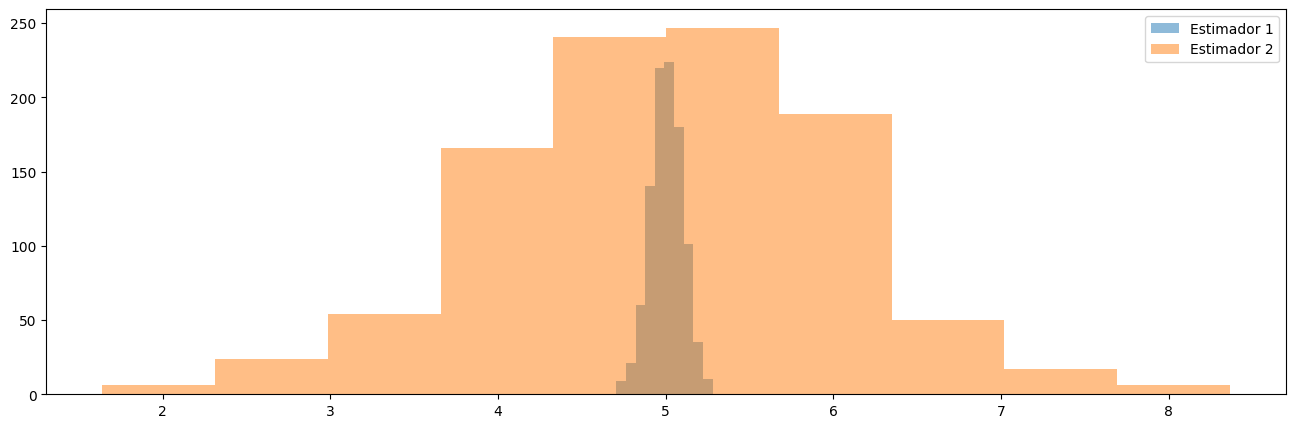

In [41]:
plt.figure(figsize=(16,5))
plt.hist(A1, label='Estimador 1', alpha=0.5)
plt.hist(A2, label='Estimador 2', alpha=0.5)
plt.legend()
plt.show()

#EJERCICIO

In [42]:
#función cálculo varianza del ruido a partir del snr dB
def var_snr(x,snrdB): #x vector de datos (señal), snrdB SNR en dB
    Px = np.mean(x**2)#estimador potencia media de la señal
    return Px/(10**(snrdB/10))

In [43]:
#datos simulados
Fo = 60 #frecuencia fundamental señal cos
A = 10 # amplitud de la señal
To = 1/Fo #periodo fundamental
Fs = 100*Fo #frecuencia muestreo según nyquist Fs >= 2 Fo
X = np.arange(0,To,1/Fs) #vector de entrada en un periodo con pasos según período de muestreo

snrdB = 10 #ruido según SNR dB
#señal limpia - objetivo
tt = A*np.sin(2*np.pi*Fo*X)
#modelo con función sinoidal contaminada con ruido Gaussiano
t = A*np.sin(2*np.pi*Fo*X) + np.sqrt(var_snr(tt,snrdB))*np.random.randn(len(X))

X = X.reshape(-1,1)#filas = realizaciones-muestras
t = t.reshape(-1,1)

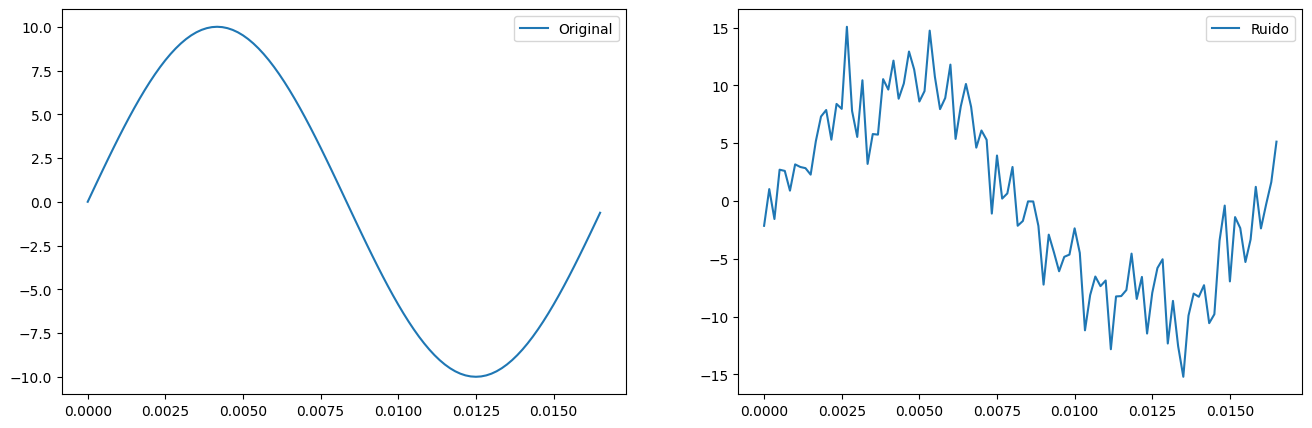

In [66]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.plot(X, tt, label='Original')
plt.legend()
plt.subplot(1,2,2)
plt.plot(X, t, label='Ruido')
plt.legend()
plt.show()

In [134]:
#solución min cuadrados regularizados
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import mean_squared_error as MSE


#generación representación polinomial
#desde la libreria sklearn
Q = np.arange(1,10)
error_noise = np.zeros(len(Q))
error_clean = np.zeros(len(Q))

#particionar datos
rs = ShuffleSplit(n_splits=1, random_state=0, test_size=0.2)
for i, (train_i, test_i) in enumerate(rs.split(X)):
   print(i)

#regresor
lambdaR = 1e-15#hiperparámetro de regularización
reg_mc = Ridge(alpha=lambdaR)
train_i = np.sort(train_i)
test_i = np.sort(test_i)

for q in Q:
  phiQ = PolynomialFeatures(degree=q, include_bias=False)
  Phi = phiQ.fit_transform(X)

  reg_mc.fit(Phi[train_i],t[train_i])
  t_mc = reg_mc.predict(Phi[test_i])

  error_noise[q-1] = MSE(t[test_i], t_mc)
  error_clean[q-1] = MSE(tt[test_i], t_mc)

0


Grado polinomio óptimo: 8
Error: 7.233916946575782


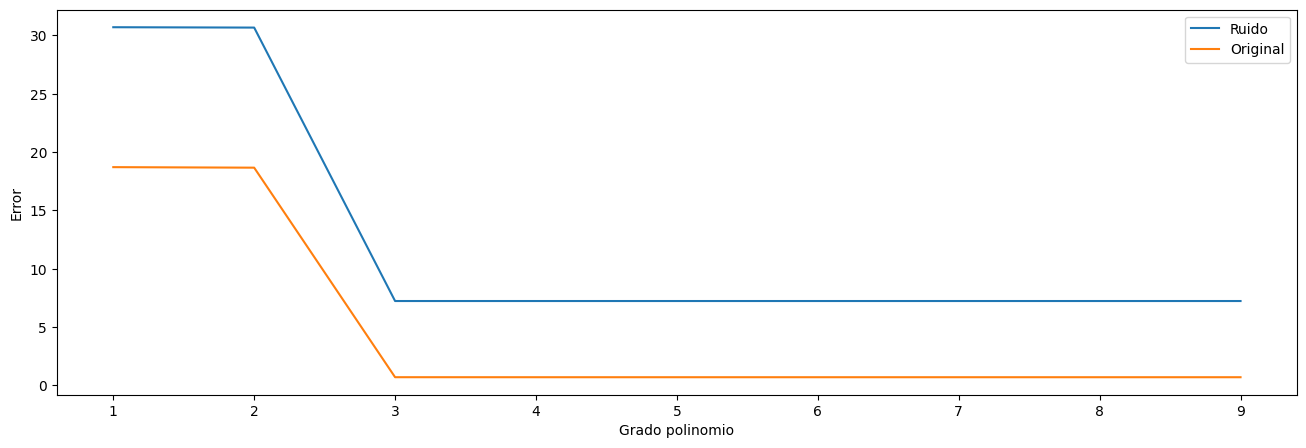

In [137]:
print(f"Grado polinomio óptimo: {np.argmin(error_noise)+1}")
print(f"Error: {error_noise[np.argmin(error_noise)]}")
plt.figure(figsize=(16,5))
plt.plot(Q, error_noise, label='Ruido')
plt.plot(Q, error_clean, label='Original')
plt.legend()
plt.xticks(Q)
plt.xlabel('Grado polinomio')
plt.ylabel('Error')
plt.show()

#Cross-Validation

In [ ]:
from sklearn.preprocessing import MinMaxScaler
X_scaled = MinMaxScaler(feature_range=(-1,1)).fit_transform(X)

Q2 = np.arange(1,50)
error_cross = np.zeros(len(Q2))
error_cross_clean = np.zeros(len(Q2))

# cross-validation with multiple splits
rs_cross = ShuffleSplit(n_splits=10, random_state=0, test_size=0.2)

lambdaR = 1e-15
reg_mc = Ridge(alpha=lambdaR, fit_intercept=False)

for q in Q2:
  phiQ = PolynomialFeatures(degree=q)
  Phi = phiQ.fit_transform(X_scaled)

  errs = []  # store errors for each split
  errs2 = []
  for train_i, test_i in rs_cross.split(X):
    reg_mc.fit(Phi[train_i], t[train_i])
    t_mc = reg_mc.predict(Phi[test_i])

    errs.append(np.sqrt(MSE(t[test_i], t_mc)))
    errs2.append(np.sqrt(MSE(tt[test_i], t_mc)))

  # mean error across splits
  error_cross[q-1] = np.mean(errs)
  error_cross_clean[q-1] = np.mean(errs2)

Grado polinomio óptimo: 5
Error: 2.527825483792788


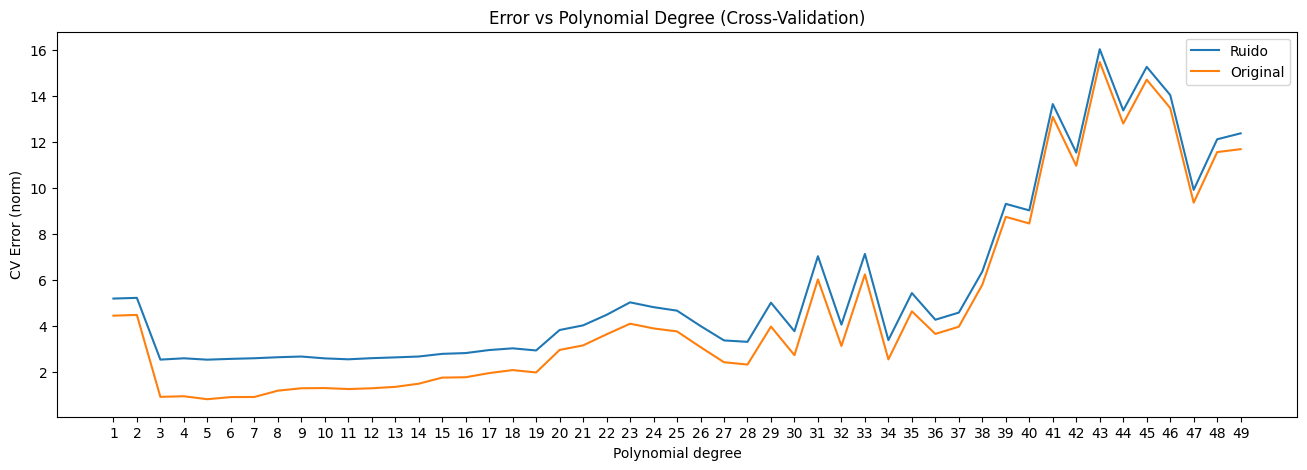

In [153]:
print(f"Grado polinomio óptimo: {np.argmin(error_cross)+1}")
print(f"Error: {error_cross[np.argmin(error_cross)]}")

plt.figure(figsize=(16,5))
plt.plot(Q2, error_cross, label='Ruido')
plt.plot(Q2, error_cross_clean, label='Original')
plt.xticks(Q2)
plt.xlabel("Polynomial degree")
plt.ylabel("CV Error (norm)")
plt.title("Error vs Polynomial Degree (Cross-Validation)")
plt.legend()
plt.show()